In [1]:
# Names: Max Collins, Marwan Bit, Nikolas Hall
# Physics 24A
# Prof. Saeta
# Final Project: Gravity Assist "Slingshot" Maneuver

In [119]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from p24asolver import P24ASolver

# Constants we'll need:


SATM = 1.0   # Mass of the satellite

    
G = 38.59 # Gravitational constant wrong units
fpsq = 4 * (np.pi)**2 # Four pi-squared

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
class Planet():
    """Allows us to create objects that represent the Sun and the planets."""
    
    def __init__(self, **kwargs):
        """
        I'm going to use Python's keyword argument mechanism to handle the parameters.

        The kwargs parameter is a dictionary of all the named parameters and their values. We can use
        the built-in 'get' method to store parameter values, which allows us to provide default values
        in cases where no value was given.

        Note that we need to call the __init__ method of P24ASolver with a list of
        variable names. The first string in each variable tuple is the variable name, which you can use to
        refer to the variable, the second is a LaTeX representation that will look nice on a plot.
        """
        #super().__init__(
         #   (('x1', '$x_1$'), ('v1', r'$\dot{x}_1$'),
         #    ('x2', '$x_2$'), ('v2', r'$\dot{x}_2$'))
        #
        # Now store variables, using defaults, if necessary
        self.mass = kwargs.get('m', 1.0)        # Mass, in solar masses
        self.radius = kwargs.get('r', 0.00047)  # Planetary radius, in AU (default is for Jupiter)
        self.rorbit = kwargs.get('ro', 1.0)     # Orbital radius, in AU (assumes perfectly circular orbits)
        self.period = np.sqrt((fpsq * (self.rorbit)**3) / G)    # Period of orbit determined by other parameters
                                                                # In denominator, G multiplied by 1 solar mass => G
        self.ω = 0
        if self.period != 0:
            self.ω = (2* np.pi)/self.period
        
    def __str__(self):
        "Produces a string representation of the planet's parameters."
        string = "Mass: " + str(self.mass) + "  Radius: " + str(self.radius) + "  Radius of Orbit: " + str(self.rorbit) + "  Period: " + str(self.period)
        return str(string)
        # Add units, and figure out how to get each attribute onto a new line.
    
    def orbit(self, R, ω, t):
        """
        Arguments: R is the radius of orbit of a planet, ω is its angular speed, and t is the time of interest.
        Returns: Cartesian coordinates for position of the planet at time t.
        """
        return (R * np.math.cos(ω * t), R * np.math.sin(ω * t))
    

 # Planets for a default simulation
SUN = Planet(m = 1.0, r = 1, ro = 0.0)        # Figure out solar radius (AU) and Jupiter's mass (solar masses)
JUP = Planet(m = .00095, r = 1, ro = 5.2)

class Satellite(P24ASolver):
    """Allows us to define an object representing our space probe. Simulates a solar system of planets with perfectly circular orbits."""
    
    def __init__(self, **kwargs):
        """
        I'm going to use Python's keyword argument mechanism to handle the parameters.

        The kwargs parameter is a dictionary of all the named parameters and their values. We can use
        the built-in 'get' method to store parameter values, which allows us to provide default values
        in cases where no value was given.

        Note that we need to call the __init__ method of P24ASolver with a list of
        variable names. The first string in each variable tuple is the variable name, which you can use to
        refer to the variable, the second is a LaTeX representation that will look nice on a plot.
        """
        super().__init__(
            (('x1', '$x_1$'), ('v1', r'$\dot{x}_1$'),
             ('x2', '$x_2$'), ('v2', r'$\dot{x}_2$'))
        )
        # Now store variables, using defaults, if necessary
        self.position = kwargs.get('r', [-1, 0])    # Satellite's position in Cartesian coordinates
                                                    # Default is x = -1 AU y = 0 AU
            
        self.velocity = kwargs.get('v', [0, 0])     # Satellite's velocity in the x- and y-directions
                                                    # Default is satellite at rest
            
        self.planets = kwargs.get('p', [SUN, JUP])  # A list of the planets that the satellite can interact with
                                                    # By default, includes the Sun and Jupiter
        
        # We treat the satellite as though it has negligible mass and no radius
        # The satellite is a point moving through space
        
        
    def __str__(self):
        "Produces a string representation of a satellite."
        string = "Position: (x, y) = " + str(self.position) + "  Velocity: (vx, vy) = " + str(self.velocity)
        return str(string)
        
        
    def derivatives(self, t, Y):
        """ Accepts: Time of interest, derivatives vector, and """
        x1, v1, x2, v2 = Y  # Unpack the values
                            # x1 = x-position, v1 = x-velocity
                            # x2 = y-position, v2 = y-velocity
        
        
        
        numPlanets = len(self.planets)
        
        Alist = []
        
        for planet in self.planets:          # For each planet in the simulation...
            xp1, xp2 = planet.orbit(planet.rorbit, planet.ω, t)    # Get the planet's cartesian position
            
            r_sq = (x1 - xp1)**2 + (x2 - xp2)**2   # Square of the satellite's distance from the current planet
            
            x = xp1 - x1
            y = xp2 - x2
            
            cosine_theta = y/np.sqrt(r_sq)
            
            sine_theta = x/np.sqrt(r_sq)
            
            # Get the components of the satellite's gravitational acceleration due to this planet
            a1 = float((G * planet.mass) / r_sq)*sine_theta
            a2 = float((G * planet.mass) / r_sq)*cosine_theta
            
#             if planet.mass == 1.0:
#                 print('accel due to sun:', '(',a1,a2,')')
            # Add those components to a list of accelerations
            Alist += [[a1, a2]]
            
        A1 = 0   # Total acceleration in the x-direction
        A2 = 0   # Total acceleration in the y-direction
        
        # Sum components to get the total x- and y-accelerations
        for a in Alist:
            A1 += a[0]
            A2 += a[1]
        
        return [v1, A1, v2, A2]   # Return a time derivative of Y
    
    



    def prepare_figure(self):
        """
        Function that creates the figure and axes for the animation.
        """

        fig, ax = plt.subplots(figsize = (20, 20))
        # We need to set the axes limits so each frame uses the same limits
        # I'll say that the center position of the first mass is at 2 and the second at 4
        ax.set_xlim((-10, 10))
        ax.set_ylim((-10, 10))

        self.shapes = [Circle((self.position), radius = .05, color = 'r')]
        
        for planet in self.planets:
            self.shapes.append(Circle((planet.rorbit, 0), radius = planet.radius, color = 'b'))

        
        for s in self.shapes:
            ax.add_patch(s)
        return fig, ax

    def draw_frame(self, t):
        """
        Draw frame for time t
        """

        x1, v1, x2, v2 = self.solution.sol(t)
        
        self.shapes = [Circle((x1,x2), radius = .05, color = 'r')]
        
        for planet in self.planets:
            self.shapes.append(Circle((planet.orbit(planet.rorbit, planet.ω, t)), radius = planet.radius, color = 'b'))
            
        for s in self.shapes:
            self.ax.add_patch(s)

#         title = self._ax.set_title(f"t = {t:.2f}", usetex=False)

        # By returning the list of Artists that have changed,
        # we speed up the animation
        return self.shapes

In [55]:
Earth = Planet()
str(Earth)
Sat = Satellite()
str(Sat)

'Position: (x, y) = [-1, 0]  Velocity: (vx, vy) = [0, 0]'

<IPython.core.display.Javascript object>


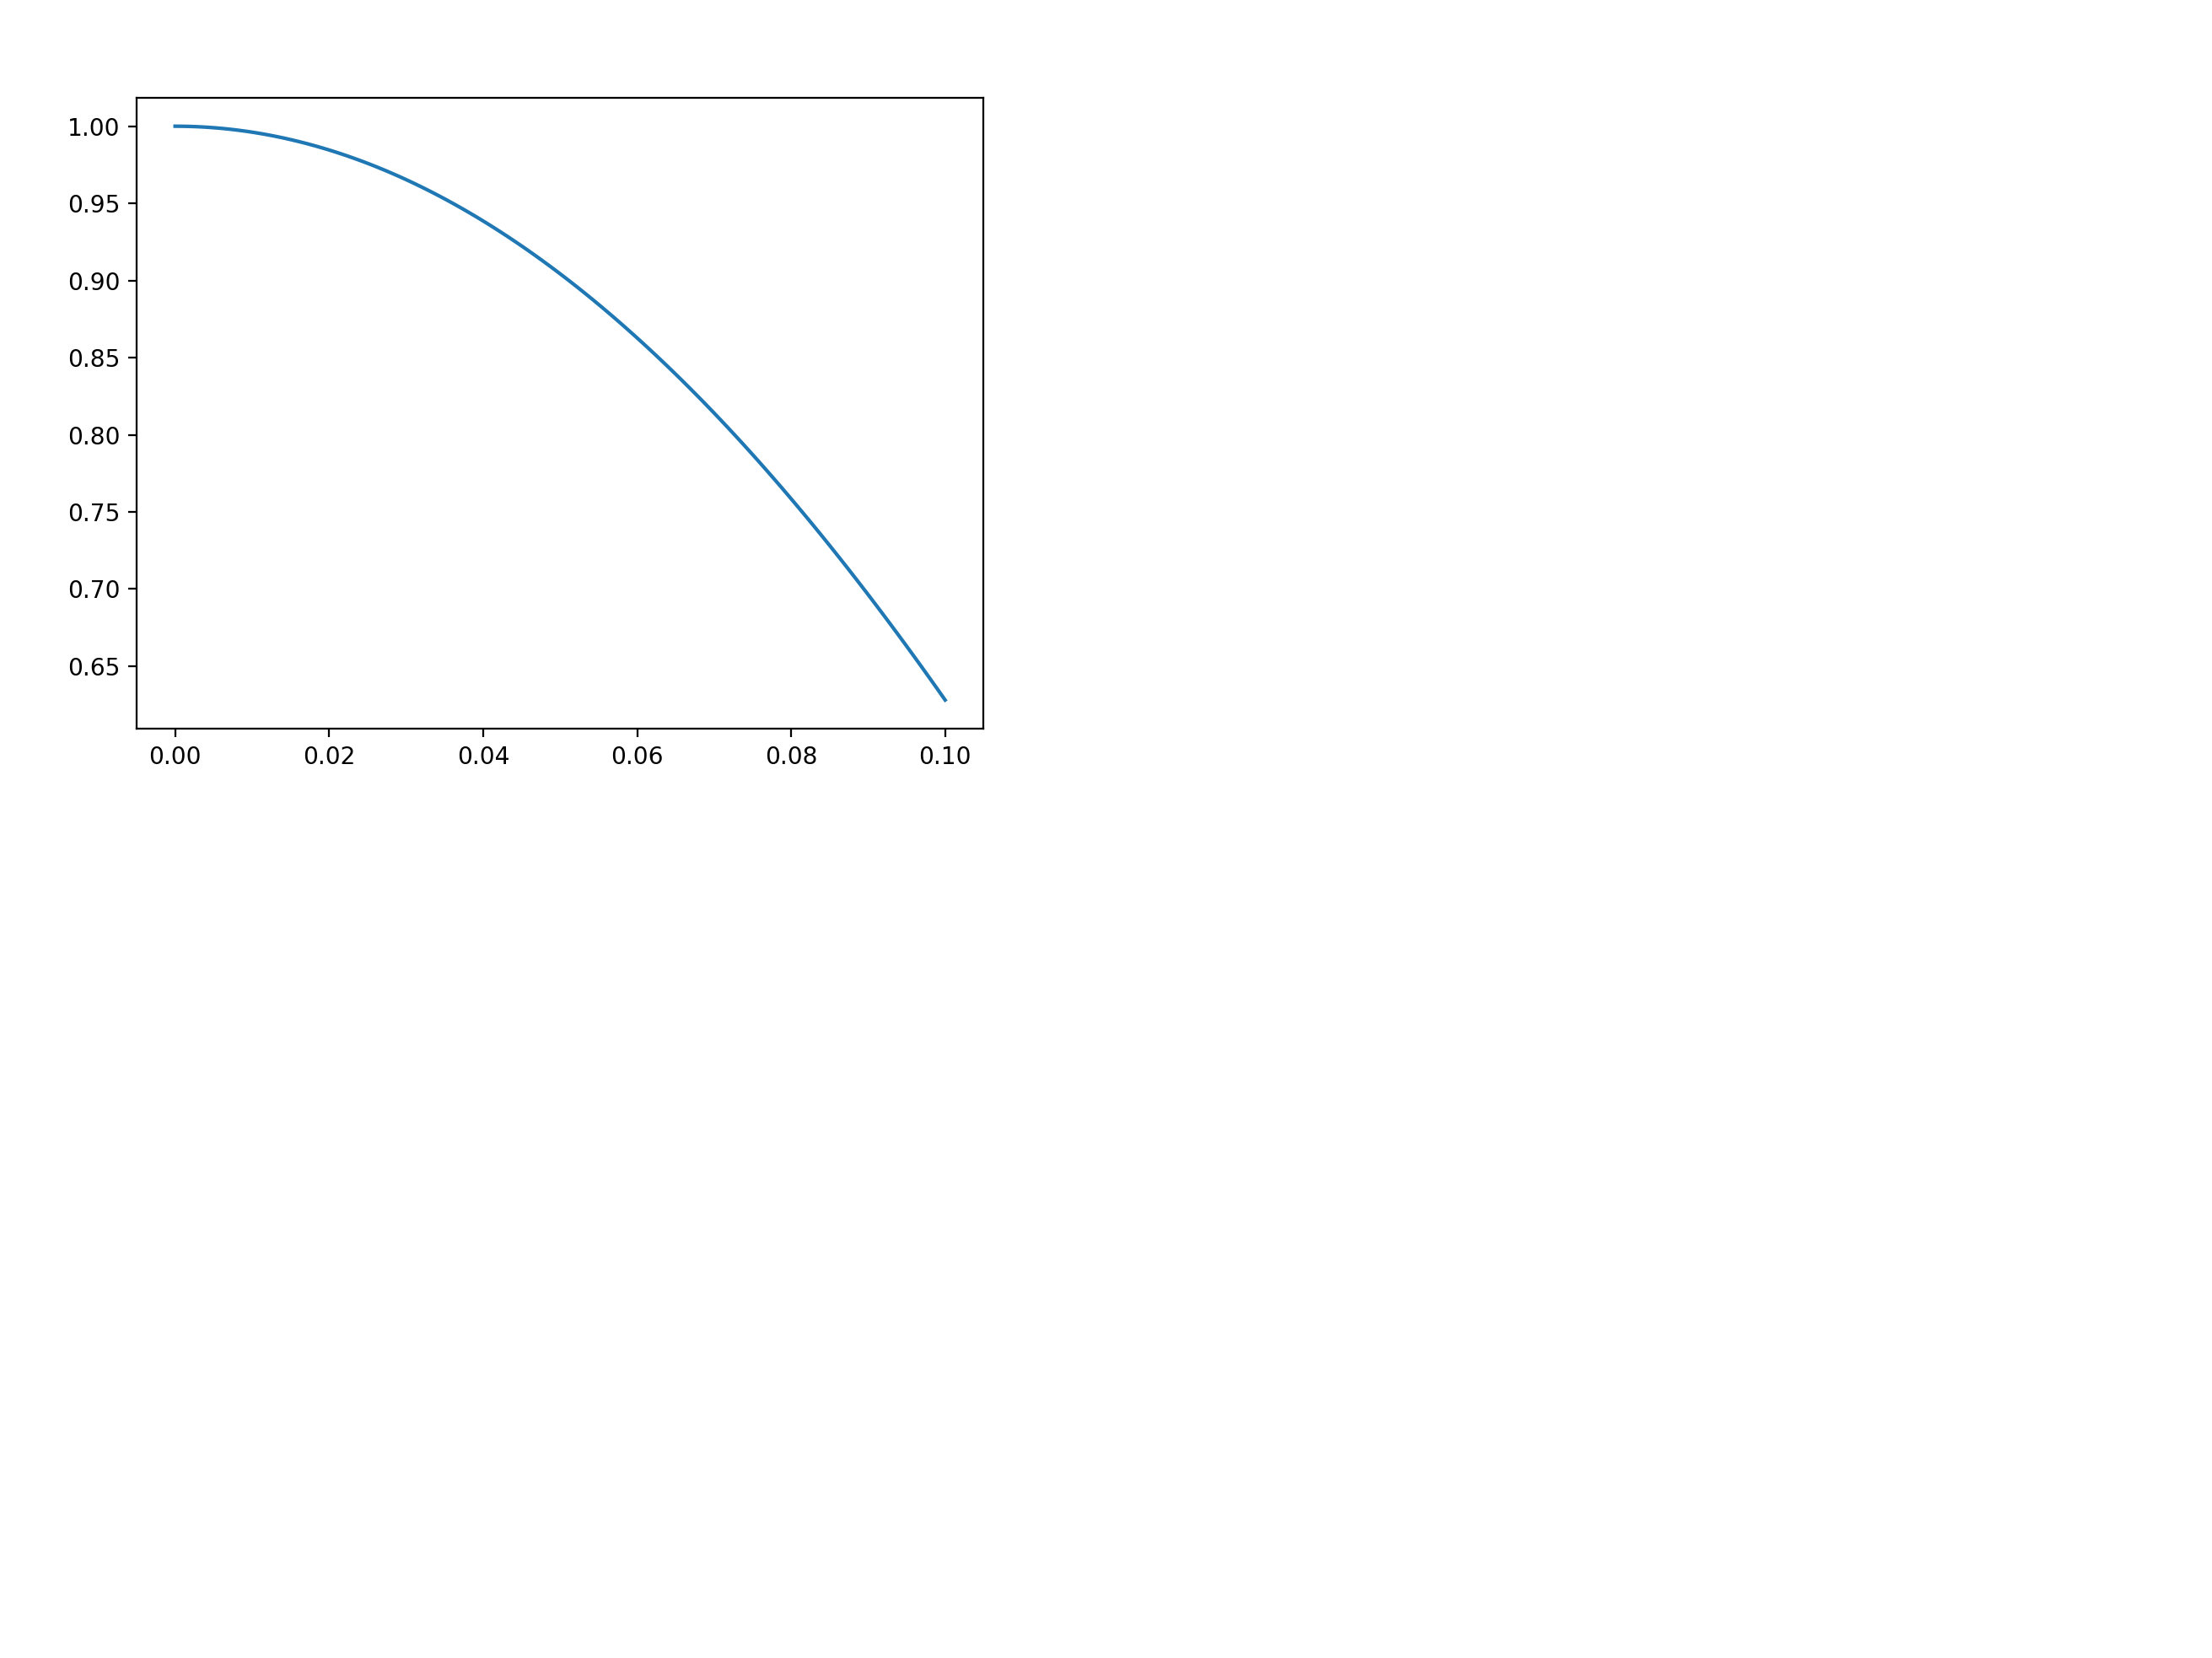

array([1., 0., 0., 0.])

In [125]:
Sat = Satellite()
rest = (1,0,0,0)
sol1 = Sat.solve(rest, (0,.1))
times = np.linspace(0,.1,100)
radii = [sol1(t)[0]**2+sol1(t)[2]**2 for t in times]
x_list = [sol1(t)[0] for t in times]
y_list = [sol1(t)[2] for t in times]

x_jup_list =[JUP.orbit(JUP.rorbit,JUP.ω, t)[0] for t in times]
fig, ax = plt.subplots()
ax.plot(times, radii)

sol1(0)

In [54]:
def boost_check(init_pos):
    """
    init_pos should be a valid entry for rest
    """
    KE = .5*

array([4.07406246e+00, 1.47410907e-05, 4.07406246e+00, 1.47410907e-05])